### Load Packages

In [1]:
import pathlib
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
%matplotlib inline
from IPython import display
import pandas as pd
import sys, subprocess
from PIL import Image

from armcodlib import *


/usr/local/lib/python2.7/dist-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)
Using TensorFlow backend.


In [2]:
print(tf.__version__)

2.0.0-alpha0


### Create arm positions dataset

In [3]:
TRAIN_BUF = 1000
BATCH_SIZE = 10
TEST_BUF = 100
DIMS = (128,128,2)
N_TRAIN_BATCHES =int(TRAIN_BUF/BATCH_SIZE)
N_TEST_BATCHES = int(TEST_BUF/BATCH_SIZE)
NB_POSTURE = 10
NB_COMMAND = 100
NB_DATA = NB_POSTURE*NB_COMMAND

In [4]:
train_command = create_random_data(NB_POSTURE, NB_COMMAND, "train")
train_images = load_and_process_images(NB_DATA, "train")
test_command = create_random_data(10,10, "test")
test_images = load_and_process_images(100, "test")

In [5]:
train_dataset = (
    tf.data.Dataset.from_tensor_slices(train_images)
    .shuffle(TRAIN_BUF)
    .batch(BATCH_SIZE)
)

test_dataset = (
    tf.data.Dataset.from_tensor_slices(test_images)
    .shuffle(TEST_BUF)
    .batch(BATCH_SIZE)
)

### Define the Gated Network as tf.keras.model object

In [41]:
class GFN(tf.keras.Model):
    """a gated autoencoder class for tensorflow
    Extends:
        tf.keras.Model
    """
    def __init__(self, **kwargs):
        super(GFN, self).__init__()
        self.__dict__.update(kwargs)
        
        self.enc = self.enc #tf.keras.Sequential(self.enc)
        self.dec = self.dec #tf.keras.Sequential(self.dec)
        #self.total_loss = 0.0
        
    @tf.function
    def encode(self, x):
        return self.enc(x)

    @tf.function
    def decode(self, z):
        return self.dec(z)
    
    @tf.function
    def compute_loss(self, x):
        z = self.encode(x)
        _x = self.decode(z)
        ae_loss = (tf.square(x[:,:,:,1] - _x[:,:,:,0]))
        #self.total_loss += ae_loss tf.reduce_mean
        return ae_loss
    
    @tf.function
    def compute_gradients(self, x):
        with tf.GradientTape() as tape:
            loss = self.compute_loss(x)
        return tape.gradient(loss, self.trainable_variables)

    def train(self, train_x):    
        gradients = self.compute_gradients(train_x)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

#    def call(self, inputs):
  #      return self.dec(self.enc(inputs))


### Define the network architecture

In [42]:
encoder = build_dense_encoder()
decoder = build_dense_decoder()

### Create Model

In [43]:
optimizer = tf.keras.optimizers.Adam(1e-3)

model = GFN(
    enc = encoder,
    dec = decoder,
    optimizer = optimizer
)
model.compile(optimizer = optimizer, 
             loss='mse',
             metrics=['accuracy'])

### Train model

In [44]:
encoder.input

<tf.Tensor 'encoder_input_5:0' shape=(None, 128, 128, 2) dtype=float32>

In [33]:
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(train_images, 
                    validation_split = 0.2,
                    epochs = 10
                   )      
                   #callbacks=[tensorboard_callback])

NotImplementedError: When subclassing the `Model` class, you should implement a `call` method.

In [45]:
losses = pd.DataFrame(columns = ['MSE'])

In [46]:
n_epochs = 100
for epoch in range(n_epochs):
    # train
    for batch, train_x in tqdm(
        zip(range(N_TRAIN_BATCHES), train_dataset), total=N_TRAIN_BATCHES
    ):
        model.train(train_x)
    # test on holdout
    loss = []
    for batch, test_x in tqdm(
        zip(range(N_TRAIN_BATCHES), train_dataset), total=N_TRAIN_BATCHES
    ):
        loss.append(model.compute_loss(train_x))
    losses.loc[len(losses)] = np.mean(loss, axis=0)
    # plot results
    display.clear_output()
    print("Epoch: {} | MSE: {}".format(epoch, losses.MSE.values[-1]))
    #plot_reconstruction(model, example_data)

KeyboardInterrupt: 

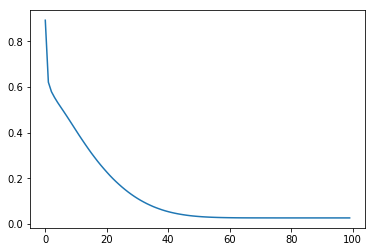

In [36]:
plt.plot(losses.MSE.values)

In [38]:
example_data = next(iter(train_dataset))
example_data_reconstructed = model.decode(model.encode(example_data))
    

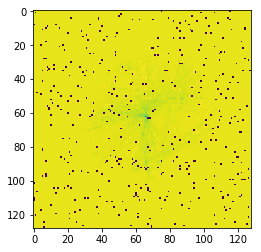

In [39]:
imshow(example_data_reconstructed[0][:,:,0])

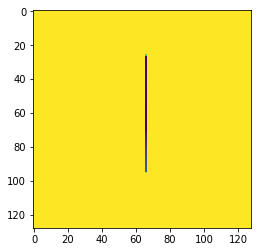

In [40]:
imshow(example_data[0][:,:,1])